In [1]:
import numpy as np
import tensorflow as tf
# next line only for colab
%tensorflow_version 2.x
# import tensorflow-datasets to be able to access the tensorflow inbuilt datasets
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

# 1. Dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


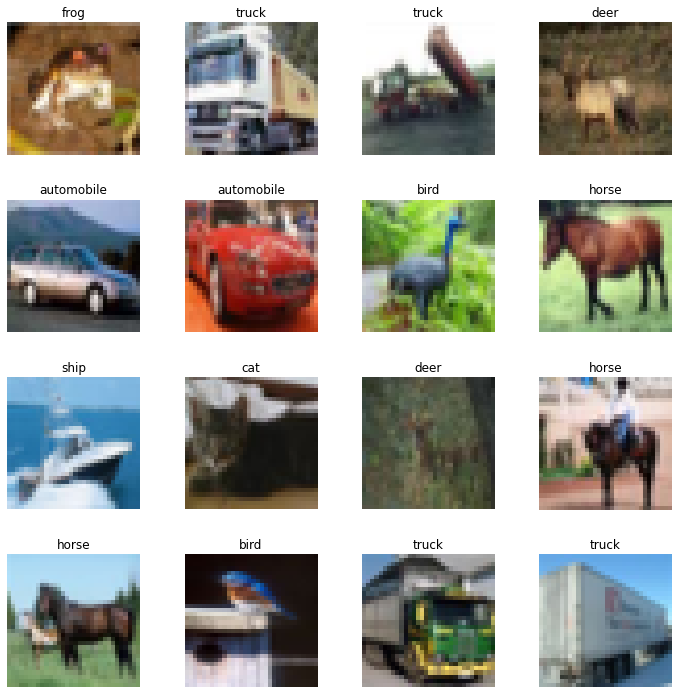

In [3]:
# Plot some images together with their labels
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4,4, figsize = (10,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(16):
  ax[i].imshow(train_images[i]/255)
  ax[i].set_title(label_names[int(train_labels[i])])
  ax[i].axis('off')

## Data Generator
### The code below can be used for data augmentation. As it only marginally increased the test accuracy for our model we chose to leave it out due to increased training time.

```
# Create a generator with certain data manipulations
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 50,
    brightness_range = (.4,.8),
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True
)

# Create an iterator using datagen.flow
train_generator = datagen.flow(train_images, train_labels, batch_size = 256)

# Plot newly generated images
fig, ax = plt.subplots(1,5, figsize = (10,10))
for img, _ in train_generator:
    for i in range(0, 5):
        ax[i].imshow(img[i])
    plt.show()
    break

# Define our own generator which returns a certain number of batches
def generator(num_batches):
  for i, train_tuple in enumerate(train_generator):
    yield train_tuple
    if i >= num_batches:
      return
      
```

### Input pipeline for the data generator

```
num_batches = 150

train_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args=(tf.constant(num_batches),))
train_dataset = train_dataset.map(lambda img, lbl: (img, tf.one_hot(tf.cast(lbl, tf.uint8),10)))
train_dataset = train_dataset.map(lambda img, lbl: (img, tf.reshape(lbl, (-1,10)))).prefetch(256)


test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_images = test_dataset_images.map(lambda img: tf.cast(img/255, tf.float32))
test_dataset_targets = test_dataset_targets.map(lambda lbl: tf.one_hot(lbl,10))
test_dataset_targets = test_dataset_targets.map(lambda lbl : tf.reshape(lbl, (-1,)))
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets)).shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(256).prefetch(256)

```

## Input pipeline


In [4]:
# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)

# We want the labels to be onehot encoded and reshaped such that they are the same dimension as the output. 
# Furthermore, we normalize the images to a scale between 1 and 0.
train_dataset_images = train_dataset_images.map(lambda img: tf.cast(img/255, tf.float32))
train_dataset_targets = train_dataset_targets.map(lambda lbl: tf.one_hot(lbl,10))
train_dataset_targets = train_dataset_targets.map(lambda lbl : tf.reshape(lbl, (-1,)))

# we use the .cache() function to store the data we need later in our memory for faster training 
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets)).cache().shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.experimental.AUTOTUNE)


# Repeat for test data
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset_images = test_dataset_images.map(lambda img: tf.cast(img/255, tf.float32))
test_dataset_targets = test_dataset_targets.map(lambda lbl: tf.one_hot(lbl,10))
test_dataset_targets = test_dataset_targets.map(lambda lbl : tf.reshape(lbl, (-1,)))

test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets)).cache().shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.experimental.AUTOTUNE)


# 2. Model

## 2.1 ResNet

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class ResidualBlock(Layer):

  def __init__(self, num_filters, kernel_size=3):
    """Initialize a Residual Block with two kernel_size x kernel_size convolutional layers.

    Arguments:
      num_filters (list): Number of filters, one for each conv layer in our ResidualBlock
      kernel_size (int): Defines the kernel size for both convolutional layers
    """
    # use the keyword super to allow our network to access the init() form the keras Layer class
    super(ResidualBlock, self).__init__()
  
    # extract the filters for our conv layers
    self.filter1, self.filter2 = num_filters

    # define set of layers
    self.ResBlockLayers = [
        tf.keras.layers.Conv2D(filters=self.filter1, kernel_size=kernel_size, padding="same",  activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=self.filter2, kernel_size=kernel_size, padding="same",  activation=None),
        tf.keras.layers.BatchNormalization()]
    
    
  # Use the decorator @tf.function to speed up the model call. 
  # Furthermore, we pass a training flag such that we only use our regularization methods during training. 
  @tf.function 
  def call(self, x, training = True):
      """Activate our ResidualBlock, by propagating the input through the ResBlock layer by layer

      Arguments:
        x (Tensor): Tensor containing the input to our ResBlock
        training (Boolean): Indicates whether regularization methods should be used or not when calling the ResBlock 

      Returns:
        x (Tensor): Tensor containing the activation of our ResBlock
      """

      y = x

      for layer in self.ResBlockLayers:
        y = layer(y, training = training)
      
      # here we apply the pointwise addition of the original input to the ResBlock's output
      y = x+y

      # after the addition we apply the activation function
      return tf.nn.relu(y)

In [6]:
class ResNet(Model):

  def __init__(self):
    """Initialize a Residual Network with a variable amount of keras.Layers and Residual Blocks
    """  
    # use the keyword super to allow our network to access the init() form the keras Model class
    super(ResNet, self).__init__()

    self.ResNetLayers = [tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same",  activation=None),
                      tf.keras.layers.BatchNormalization(),
                      tf.keras.layers.ReLU()]  

    self.ResNetLayers.append(ResidualBlock(num_filters=[64,64]))
    self.ResNetLayers.append(ResidualBlock(num_filters=[64,64]))

    self.PoolingBlock1 = [tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides = 2, padding="valid",  activation=None),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.ReLU(),
                          tf.keras.layers.Dropout(0.5)]

    self.ResNetLayers.extend(self.PoolingBlock1)

    self.ResNetLayers.append(ResidualBlock(num_filters=[128,128]))
    self.ResNetLayers.append(ResidualBlock(num_filters=[128,128]))

    self.PoolingBlock2 = [tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides = 2, padding="valid",  activation=None),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.ReLU(),
                          tf.keras.layers.Dropout(0.5)]

    self.ResNetLayers.extend(self.PoolingBlock2)

    self.ResNetLayers.append(ResidualBlock(num_filters=[256,256]))
    self.ResNetLayers.append(ResidualBlock(num_filters=[256,256]))

    self.Classifier = [tf.keras.layers.GlobalAveragePooling2D(),
                       tf.keras.layers.Dense(units=128, activation=None), 
                       tf.keras.layers.BatchNormalization(), 
                       tf.keras.layers.ReLU(),
                       tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)]
   
    self.ResNetLayers.extend(self.Classifier)

  @tf.function    
  def call(self, x, training = True):
    """Activate our model propagating the input through the network layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our network
      training (Boolean): Indicates whether regularization methods should be used or not when calling the model 

    Returns:
      x (Tensor): Tensor containing the probabilities for the ten classes
    """

    for layer in self.ResNetLayers:
      x = layer(x, training = training)
    return x

# DenseNet

We based our following DenseNet structure on the approach of the authors of the original paper (Densely Connected Convolutional Networks 2018).

There each Layer of a Denseblock (see. Figure 1 on Courseware) takes all preceeding feature maps as input.


In [ ]:
class TransitionLayers(Layer):
  
  def __init__(self, num_filters):
    """Initialize a Transition Layer consisting of two Convolutional Layers (one acts as a Bottleneck, the other as Pooling Layer). 
    These Layers can be placed between the Dense Blocks in our DenseNet.

    Arguments:
      num_filters (list): Number of filters, one for each conv layer in our Transition Layer.
    """  

    # use the keyword super to allow our network to access the init() form the keras Layer class
    super(TransitionLayers, self).__init__()

    # extract filters
    self.filter1, self.filter2 = num_filters

    # define set of layers
    self.TransitionLayer = [
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),                           
        tf.keras.layers.Conv2D(filters=self.filter1, kernel_size=1, strides=1, padding="valid",  activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=self.filter2, kernel_size=2, strides=2, padding="valid",  activation=None),
        tf.keras.layers.Dropout(0.5)]

  @tf.function 
  def call(self, x, training=True):
    """Activate our Transition Layers by propagating the input through them

    Arguments:
      x (Tensor): Tensor containing the input to our Transition Layers
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Transition Layer

    Returns:
      x (Tensor): Tensor containing the drive of the Transition Layers
    """
    for layer in self.TransitionLayer:
      x = layer(x, training = training)
    return x

In [ ]:
class Block(Layer):

  def __init__(self, filter, growth_rate):
    """Initialize a Block with two Convolutional Layers (the first one acts a Bottleneck, the other is a normal 3x3 Convolutional Layer). 
    At the end of each Block, the input is concatenated to the Blocks output. Groups of Blocks are connected by Transition Layers.

    Arguments:
      filter (int): Defines number of filters for the Bottleneck Layer
      growth_rate (int): Defines the number of added channels per concatenation
    """  

    # use the keyword super to allow our network to access the init() from the keras Layer class
    super(Block, self).__init__()

    self.BlockLayers = [
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=filter, kernel_size=1, padding="valid",  activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=growth_rate, kernel_size=3, padding="same",  activation=None)]

    # We use this layer to concatenate the input of a Block to its output
    self.concatenate = tf.keras.layers.Concatenate()

  @tf.function 
  def call(self, x, training=True):
    """Activate one Block by propagating the input through the Block layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our Block
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Block 

    Returns:
      x (Tensor): Tensor containing the concatenated feature maps
    """
    y = x

    for layer in self.BlockLayers:
      y = layer(y, training = training)

    # concatenate input to output
    y = self.concatenate([y,x])
    return y


In [ ]:
class DenseBlock(Layer):

  def __init__(self, filter, growth_rate, num_blocks):
    """Initialize a DenseBlock consiting of several Blocks

    Arguments:
      filter (int): Defines number of filters for the Bottleneck Layer
      growth_rate (int): Defines the number of added channels per concatenation
      num_blocks (int): Number of consecutive Blocks
    """  

    # use the keyword super to allow our network to access the init() from the keras Layer class
    super(DenseBlock, self).__init__()

    self.DenseBlockLayers = [Block(filter, growth_rate) for _ in range(num_blocks)]


  @tf.function 
  def call(self, x, training=True):
    """Activate one DenseBlock by propagating the input through the DenseBlock layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our DenseBlock
      training (Boolean): Indicates whether regularization methods should be used or not when calling the DenseBlock 

    Returns:
      x (Tensor): Outputs the feature maps of a whole DenseBlock
    """

    for block in self.DenseBlockLayers:
      x = block(x, training = training)

    return x

In [ ]:
class DenseNetwork(Model):

  def __init__(self):
    """Initialize a DenseNet with a variable amount of keras.Layers
    """  
    # use the keyword super to allow our network to access the init() form the keras Model class
    super(DenseNetwork, self).__init__()

    self.DenseNetLayers = [tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same",  activation=None)]

    self.DenseNetLayers.append(DenseBlock(filter=32, growth_rate=32, num_blocks=4))

    self.DenseNetLayers.append(TransitionLayers(num_filters=[32,64]))

    self.DenseNetLayers.append(DenseBlock(filter=64, growth_rate=64, num_blocks=4))

    self.DenseNetLayers.append(TransitionLayers(num_filters=[64,128]))

    self.DenseNetLayers.append(DenseBlock(filter=128, growth_rate=128, num_blocks=4))


    self.Classifier = [tf.keras.layers.BatchNormalization(),
                       tf.keras.layers.ReLU(),
                       tf.keras.layers.GlobalAvgPool2D(), 
                       tf.keras.layers.Dense(units=128, activation=None), 
                       tf.keras.layers.BatchNormalization(), 
                       tf.keras.layers.ReLU(),
                       tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)]
   
    self.DenseNetLayers.extend(self.Classifier)

  @tf.function    
  def call(self, x, training = True):
    """Activate our model propagating the input through the network layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our network
      training (Boolean): Indicates whether regularization methods should be used or not when calling the model 

    Returns:
      x (Tensor): Tensor containing the probabilities for the ten classes
    """

    for layer in self.DenseNetLayers:
      x = layer(x, training = training)
    return x

# 3. Training and Analysis

In [14]:
@tf.function
def train_step(model, input, target, loss_function, optimizer, training = True):
  """Perform a training step for a given Neural Network by
  1. Propagating the input through the network
  2. Calculating the loss between the networks output and the true targets 
  2. Performing Backpropagation and Updating the trainable variables witht the calculated gradients 
 
  Arguments:
    model (Model): given instance of an initialised Neural Network with all its parameters
    input (EagerTensor): Tensor containing the input data 
    target (EagerTensor): Tensor containing the respective targets 
    loss_function (keras.losses): function from keras to calculate the loss
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 
 
  Returns:
    loss (EagerTensor): Tensor containing the loss of the Network 
  """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    # 1.
    prediction = model(input, training)
    # 2.
    loss = loss_function(target, prediction)
    # 3.
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
 
  return loss 
 
def test(model, test_data, loss_function, training = False):
  """Tests the models accuracy and loss over the given data set with a given loss_function
 
  Arguments:
    model (Model): given instance of an initialised Neural Network with all its parameters
    test_data (Dataset): test dataset to test the NN on 
    loss_function (keras.losses): function from keras to calculate the loss 
 
  Returns:
    test_loss (float): Average loss of the Neural Network over the test set
    test_accuracy (float): Average accuray of the Neural Network over the test set
  """
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []
  
  for (input, target) in test_data:
    prediction = model(input, training)
    
    # calculates the loss value (as a tensors) for an entire batch 
    sample_test_loss = loss_function(target, prediction)
 
    # creates a boolean array of dimension (100,) for each batch 
    # each entry represents whether one (sequence, label) pair was predicted correctly 
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
 
    # take the mean over each boolean array to obtain the average accuracy for one batch 
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
 
    # append the mean of all batch accuracies  
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
 
  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)
 
  return test_loss, test_accuracy

In [15]:
# Function to time the duration of each epoch
def timing(start):
  now = time.time()
  time_per_training_step = now - start
  return round(time_per_training_step, 4)

In [16]:
def visualization(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs):  
  # Visualize accuracy and loss for training and test data. 
  # One plot training and test loss.
  # One plot training and test accuracy.

  # change the style of the plots to a nicer theme

  plt.style.use('ggplot')
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))
  # plot for average loss
  ax[0].plot(train_losses, label='training')
  ax[0].plot(test_losses, label='test')
  ax[0].set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {num_epochs} epochs')
  ax[0].legend()

  # plot for average accuracy, with annotation for the last accuracy value on our test data 
  ax[1].plot(train_accuracies, label='training')
  ax[1].plot(test_accuracies, label='test')
  ax[1].set(ylabel='Accuracy', xlabel='Epochs', title=f'Average accuracy over {num_epochs} epochs')
  ax[1].legend()

  best_test_acc_indx = np.argmax(test_accuracies)
  best_test_acc = round(test_accuracies[best_test_acc_indx], 4)
  if best_test_acc > 0.3:
    ax[1].annotate(f'best test accuracy {best_test_acc*100}%', xy=(best_test_acc_indx, best_test_acc), xytext=(best_test_acc_indx/2, best_test_acc-0.25), arrowprops=dict(facecolor='steelblue', shrink=0.05))
  plt.show()

In [17]:
def trainModel(network, name, num_epochs=150, learning_rate=0.001, running_average_factor=0.95):  
  # From IPython.display we import clear_output() in order to be able to clear the print statements after each epoch
  from IPython.display import clear_output

  tf.keras.backend.clear_session()

  ### Hyperparameters
  num_epochs = num_epochs
  learning_rate = learning_rate
  running_average_factor = running_average_factor
  
  # Initialize the model.
  model = network

  # Initialize the loss: categorical cross entropy.
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(learning_rate)
  # Initialize the optimizer: Adam with default parameters.
  optimizer = tf.keras.optimizers.Adam()
  
  # Initialize lists for later visualization.
  train_losses = []
  test_losses = []
  test_accuracies = []
  train_accuracies = []
  
  # testing once before we begin on the test data
  test_loss, test_accuracy = test(model = model, test_data = test_dataset, loss_function = cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  
  # check how model performs on train data once before we begin
  train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  print("Initial Train Accuracy: " + str(round(train_accuracy, 4)))
  print("Initial Test Accuracy: " + str(round(test_accuracy, 4)))

  # We want our model to have a better test accuracy than 85% (see below)
  best_test_sofar = 0.85

  # We train for num_epochs epochs.
  for i, epoch in enumerate(range(num_epochs)):
      
      start = time.time()

      # training (and checking in with training)
      running_average = 0
      for (input,target) in train_dataset:
          train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
          running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
      train_losses.append(running_average)
  
      # testing
      test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
      test_losses.append(test_loss)

      change_test = test_accuracy-test_accuracies[-1]
      test_accuracies.append(test_accuracy)

      _, train_accuracy = test(model, train_dataset, cross_entropy_loss)
      change_train = train_accuracy-train_accuracies[-1]
      train_accuracies.append(train_accuracy)

      # We print useful information about each epoch
      clear_output()
      print('Epoch: __ ' + str(epoch+1))
      print('Train Accuracy: ' + str(round(train_accuracy, 4)))
      print('Train Auccuracy Difference to Previous Epoch: ' + str(round(change_train,4)))
      print('Best Train Accuracy So Far: ' + str(round(np.max(train_accuracies),4)) + ' Reached in Epoch: ' + str(np.argmax(train_accuracies)))
      print()
      print('Test Accuracy: ' + str(round(test_accuracy, 4)))
      print('Test Auccuracy Difference to Previous Epoch: ' + str(round(change_test,4)))
      print('Best Test Accuracy So Far: ' + str(round(np.max(test_accuracies),4)) + ' Reached in Epoch: ' + str(np.argmax(test_accuracies)))
      print()
      print(f"This epoch took {timing(start)} second")
      print()

      visualization(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

    # We save the model that was able to archieve the best test accuracy over all epochs (The first model we save needs to surpass 85%)
      if (test_accuracy > best_test_sofar):
        best_test_sofar = test_accuracy
        model.save(f'best_model_{name}')

  print()
  model.summary()


Epoch: __ 150
Train Accuracy: 0.9803
Train Auccuracy Difference to Previous Epoch: -0.0009
Best Train Accuracy So Far: 0.9835 Reached in Epoch: 144

Test Accuracy: 0.8796
Test Auccuracy Difference to Previous Epoch: -0.0032
Best Test Accuracy So Far: 0.8908 Reached in Epoch: 144

This epoch took 47.3599 second



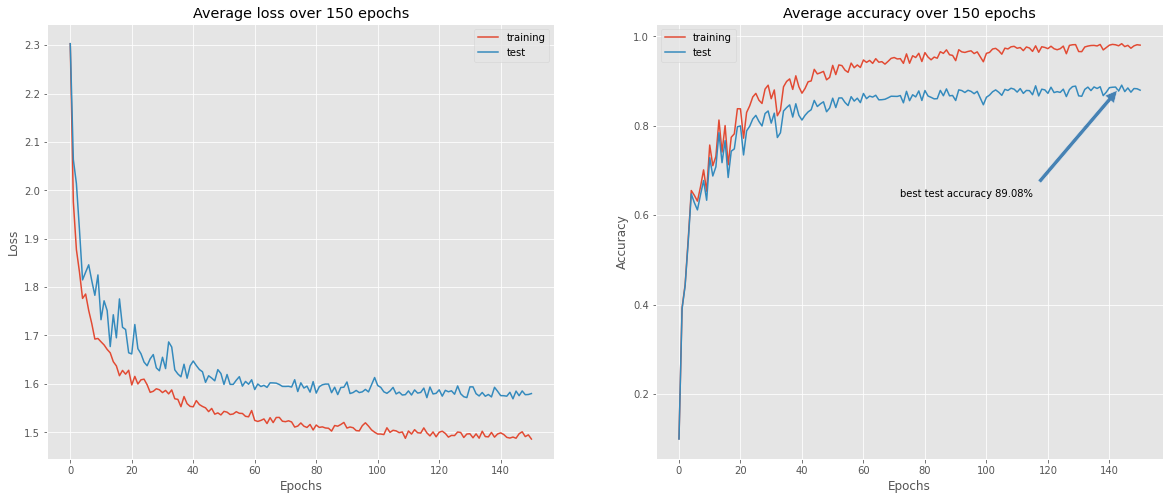


Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
residual_block (ResidualBloc multiple                  74368     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  74368     
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  32896     
_________________________________________________________________
batch_normalization_5 (Batch multiple                  512

In [18]:
trainModel(ResNet(), "ResNet")

Epoch: __ 149
Train Accuracy: 0.9684
Train Auccuracy Difference to Previous Epoch: 0.0167
Best Train Accuracy So Far: 0.9722 Reached in Epoch: 142

Test Accuracy: 0.862
Test Auccuracy Difference to Previous Epoch: 0.0198
Best Test Accuracy So Far: 0.8649 Reached in Epoch: 142

This epoch took 51.1256 second



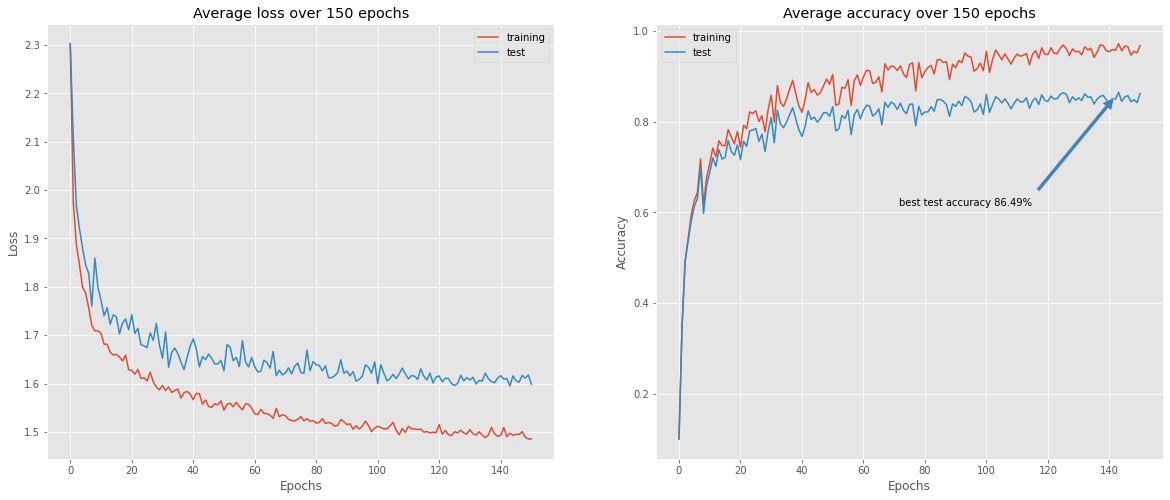

Model: "dense_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  49152     
_________________________________________________________________
transition_layers (Transitio multiple                  14176     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  192512    
_________________________________________________________________
transition_layers_1 (Transit multiple                  54976     
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  761856    
_________________________________________________________________
batch_normalization_28 (Batc multiple                

In [ ]:
trainModel(DenseNetwork(), "DenseNet")

# Compare Parameters 

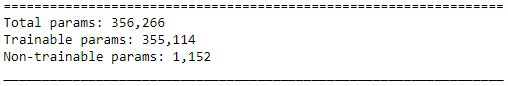

In [22]:
from PIL import Image

Image.open('week5_params.jpg')

Compared to the model architecture of week 5, both our implementations of ResNet and DenseNet have way more parameters (reaching beyond 1 Million).
By using Residual-/Dense-Blocks we allow our network to be even deeper without having a too high risk of overfitting.
\
\
Although our DenseNet has only 1/3 of the parameters of our ResNet, they both require more training time per epoch (around 50 sec.) than our Simple Convolutional Network from last week.
\
\
Furthermore, our ResNet architecture seems to produce higher test accuracies in less epochs than our DenseNet (ResNet: 89% in epoch 144, DenseNet: 86% in epoch 142). This could be due to fewer overall parameters in our DenseNet.